## Multi-scale Patch Nearest-Neighbor (MPNN) ##

This method GPNN(Drop the GAN)-inspired downscaling and upscaling architecture with constant patch size to inpaint coarse-to-fine structures.

Patchmatch implementation based on https://github.com/harveyslash/PatchMatch, modified for inpainting task and multi-scale processing.

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt



class PatchMatch(object):
    def __init__(self, img, mask, patch_size, downscale_factor=2):
        """
        Initialize Patchmatch Object.
        This method also randomizes the nnf , which will eventually
        be optimized.
        """
        assert img.shape[:2] == mask.shape[:2], "Unequal input dimensions"
        self.patch_size = patch_size
        self.downscale_factor = downscale_factor

        # for this implementation assume single contiguous mask

        # threshold mask to ensure boolean
        mask = np.where(mask > 0.5, 1, 0)

        # create a list of downsized masks
        self.masks = [mask]
        dim_mask_max = self.get_max_bounding_dim(*self.get_bounding_box(mask))
        while (dim_mask_max >= patch_size / 3):
            self.masks.append(cv2.resize(self.masks[-1], (round(self.masks[-1].shape[1] / downscale_factor),
                              round(self.masks[-1].shape[0] / downscale_factor)), interpolation=cv2.INTER_NEAREST))
            dim_mask_max = self.get_max_bounding_dim(
                *self.get_bounding_box(self.masks[-1]))
        self.masks.reverse()

        # create rescaled source images
        self.images = []
        for m in self.masks:
            self.images.append(cv2.resize(
                img, (m.shape[1], m.shape[0])))#, interpolation=cv2.INTER_NEAREST))
        self.images.append(img)

        self.nnf = np.zeros(shape=(2, self.masks[0].shape[0], self.masks[0].shape[1])).astype(
            np.int32)  # the nearest neighbour field

        self.current_size_index = 0
        self.pad_size = self.patch_size // 2

        self.image_blurred = None

        self.initialise_nnf()

    def initialise_nnf(self):
        """
        Set up a random NNF
        Then calculate the distances to fill up the NND
        :return:
        """
        mask = self.masks[self.current_size_index]
        masked_indices = np.where(mask == 1)
        unmasked_indices = np.where(mask == 0)
        self.padded_image = np.pad(self.images[self.current_size_index], ((self.pad_size, self.pad_size), (
            self.pad_size, self.pad_size), (0, 0)), mode='constant', constant_values=np.nan)

        # Initialize unmasked areas with their own coordinates
        self.nnf[0][unmasked_indices] = np.array(
            unmasked_indices[1])
        self.nnf[1][unmasked_indices] = np.array(
            unmasked_indices[0])

        # only randomize masked nnf in first iteration
        if self.current_size_index == 0:
            self.nnf[0][masked_indices] = np.random.randint(
                mask.shape[1], size=len(masked_indices[0]))
            self.nnf[1][masked_indices] = np.random.randint(
                mask.shape[0], size=len(masked_indices[0]))

        self.nnf = self.nnf.transpose((1, 2, 0))

        print("nnf shape", self.nnf.shape)
        # the distance map for the nnf
        self.nnd = np.zeros(
            shape=(mask.shape[0], mask.shape[1]))

        print("nnd shape", self.nnd.shape)

        for y, x in zip(*masked_indices):
            pos = self.nnf[y, x]
            self.nnd[y, x] = self.cal_dist(
                y, x, pos[1], pos[0])

    def cal_dist(self, ay, ax, by, bx):
        """
        Calculate distance between a patch in A to a patch in B.
        :return: Distance calculated between the two patches
        """
        ay += self.pad_size
        ax += self.pad_size
        bx += self.pad_size
        by += self.pad_size

        dx0 = dy0 = self.pad_size
        dx1 = dy1 = self.pad_size + 1

        # Ensure indices are within bounds
        ay = np.clip(ay, dy0, self.padded_image.shape[0] - dy1)
        ax = np.clip(ax, dx0, self.padded_image.shape[1] - dx1)
        by = np.clip(by, dy0, self.padded_image.shape[0] - dy1)
        bx = np.clip(bx, dx0, self.padded_image.shape[1] - dx1)

        # Extract patches
        patch1 = self.padded_image[ay - dy0:ay + dy1, ax - dx0:ax + dx1]
        patch2 = self.padded_image[by - dy0:by + dy1, bx - dx0:bx + dx1]
        mask_patch = self.masks[self.current_size_index][by -
                                                         dy0:by + dy1, bx - dx0:bx + dx1]

        # Check for masked pixels in the patch
        if np.any(mask_patch > 0):
            return 99999  # Return a high distance for patches with masked pixels

        # Replace NaNs in patches with 0
        patch1_no_nan = np.nan_to_num(patch1)
        patch2_no_nan = np.nan_to_num(patch2)

        # Replaced original use of squared diff, abs empirically produces more robust matches 
        # against noise perturbations in this use case 
        abs_diff = np.abs(patch1_no_nan - patch2_no_nan)
        return np.sum(abs_diff) / ((dx1 + dx0) * (dy1 + dy0))

    def reconstruct_image(self):
        """
        Reconstruct image using the NNF and img_a.
        :param img_a: the patches to reconstruct from
        :return: reconstructed image
        """

        img_a = self.images[self.current_size_index]
        # img_a = self.images[-1]

        final_img = np.zeros_like(img_a)
        height = self.nnf.shape[0]
        width = self.nnf.shape[1]
        scale = img_a.shape[0] // self.nnf.shape[0]
        for i in range(width):
            for j in range(height):
                y, x = self.nnf[j, i]
                if final_img[scale * j:scale * (j + 1), scale * i:scale * (i + 1)].shape == img_a[scale * x:scale * (x + 1), scale * y:scale * (y + 1)].shape:
                    final_img[scale * j:scale * (j + 1), scale * i:scale * (
                        i + 1)] = img_a[scale * x:scale * (x + 1), scale * y:scale * (y + 1)]
        return final_img

    def gaussian_kernel(self, size, sigma=1):
        """Generate a Gaussian kernel."""
        x = np.arange(-size//2 + 1., size//2 + 1.)
        x, y = np.meshgrid(x, x)
        kernel = np.exp(-(x**2 + y**2) / (2. * sigma**2))
        return kernel / kernel.sum()

    def reconstruct_avg_gaussian(self, patch_size=5, sigma=1):
        """
        Reconstruct the image using averages of Gaussian-weighed patches
        """
        img = self.images[self.current_size_index]

        height, width = img.shape[:2]
        final_img = np.zeros_like(img)
        gaussian_sum = np.zeros_like(img, dtype=np.float64)

        # Generate Gaussian kernel
        g_kernel = self.gaussian_kernel(patch_size, sigma)[:, :, np.newaxis]

        # Iterate over each pixel in NNF
        for y in range(height):
            for x in range(width):
                source_x, source_y = self.nnf[y, x]

                # Define source patch bounds
                src_top, src_bottom = max(
                    source_y - patch_size // 2, 0), min(source_y + patch_size // 2 + 1, height)
                src_left, src_right = max(
                    source_x - patch_size // 2, 0), min(source_x + patch_size // 2 + 1, width)

                tgt_top, tgt_bottom = max(
                    y - patch_size // 2, 0), min(y + patch_size // 2 + 1, height)
                tgt_left, tgt_right = max(
                    x - patch_size // 2, 0), min(x + patch_size // 2 + 1, width)

                overlap_height = min(src_bottom - src_top,
                                     tgt_bottom - tgt_top)
                overlap_width = min(src_right - src_left, tgt_right - tgt_left)

                if overlap_height > 0 and overlap_width > 0:
                    # Extract patch and its corresponding kernel part
                    patch = img[src_top:src_top + overlap_height,
                                src_left:src_left + overlap_width]
                    kernel_part = g_kernel[:overlap_height, :overlap_width]

                    # Element-wise multiply and add to final image and gaussian sum
                    final_img[tgt_top:tgt_top + overlap_height,
                              tgt_left:tgt_left + overlap_width] += patch * kernel_part
                    gaussian_sum[tgt_top:tgt_top + overlap_height,
                                 tgt_left:tgt_left + overlap_width] += kernel_part
        # Normalize the final image
        final_img /= np.maximum(gaussian_sum, 1e-8)  # Prevent division by zero

        return final_img

    def upsample_nnf(self, size):
        """
        Upsample NNF based on size. It uses nearest neighbour interpolation
        :param size: INT size to upsample to.

        :return: upsampled NNF
        """
        # convert 2 channel nnf to 3 channels for cv2's resize
        # Create a third channel filled with zeros
        temp = np.dstack((self.nnf, np.zeros(self.nnf.shape[:2])))

        img = np.zeros(shape=(size[0], size[1], 2), dtype=np.int32)
        aw_ratio = ((size[1]) // self.nnf.shape[1])
        ah_ratio = ((size[0]) // self.nnf.shape[0])

        temp = cv2.resize(temp, (img.shape[1], img.shape[0]),
                          interpolation=cv2.INTER_NEAREST)

        for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
                pos = temp[i, j]
                img[i, j] = pos[0] * aw_ratio, pos[1] * ah_ratio

        img = img.transpose((2, 0, 1))
        return img

    def visualize(self):
        """
        Get the NNF visualisation
        :return: The RGB Matrix of the NNF
        """
        nnf = self.nnf

        print(nnf.shape)

        img = np.zeros((nnf.shape[0], nnf.shape[1], 3), dtype=np.uint8)

        cur_image = self.images[self.current_size_index]

        for i in range(nnf.shape[0]):
            for j in range(nnf.shape[1]):
                pos = nnf[i, j]
                img[i, j, 0] = int(255 * (pos[0] / cur_image.shape[1]))
                img[i, j, 2] = int(255 * (pos[1] / cur_image.shape[0]))

        return img

    def inpaint(self, iters=2, rand_search_radius=200, queue=None):
        """
        Optimize the NNF using PatchMatch Algorithm
        :param iters: number of iterations
        :param rand_search_radius: max radius to use in random search
        :return:
        """
        self.current_size_index = 0
        self.image_blurred = self.images[0]
        for i, mask in enumerate(self.masks):
            self.propagate(iters, rand_search_radius)
            inpainted_image = self.reconstruct_image()
            # inpainted_image = self.reconstruct_avg_gaussian(patch_size=3, sigma=2)
            plt.imshow(inpainted_image)
            plt.show()

            plt.imshow(self.visualize())
            plt.show()

            if i < len(self.masks) - 1:
                self.nnf = self.upsample_nnf(self.masks[i+1].shape)
                upscaled_inpaint = cv2.resize(
                    inpainted_image, (self.images[i+1].shape[1], self.images[i+1].shape[0]), interpolation=cv2.INTER_NEAREST)
                mask = self.masks[i+1] > 0
                self.images[i+1][mask] = upscaled_inpaint[mask]
                # self.image_blurred = cv2.GaussianBlur(self.images[i+1] + 0.1 * np.random.randn(*self.images[i+1].shape), (3, 3), 0)
                self.image_blurred = self.images[i+1] # perturbed results don't work very well here empirically :(
                # add random noise
                self.current_size_index += 1
                self.initialise_nnf()

    def propagate(self, iters=2, rand_search_radius=200, queue=None):
        """
        Optimize the NNF using PatchMatch Algorithm
        :param iters: number of iterations
        :param rand_search_radius: max radius to use in random search
        :return:
        """
        mask = self.masks[self.current_size_index]
        unmasked_indices = np.where(mask == 0)

        current_image = self.image_blurred

        width = current_image.shape[1]
        height = current_image.shape[0]

        for it in range(iters):

            #  alternate directions each iteration
            is_even = it % 2 == 0
            ystart, yend, ystep = (0, height, 1) if is_even else (
                height - 1, -1, -1)
            xstart, xend, xstep = (0, width, 1) if is_even else (
                width - 1, -1, -1)

            for ay in range(ystart, yend, ystep):
                for ax in range(xstart, xend, xstep):
                    # Work only on masked pixels
                    if mask[ay, ax] == 1:
                        # get current best offsets and score
                        xbest, ybest = self.nnf[ay, ax]
                        dbest = self.nnd[ay, ax]

                        # propagate best values from neighbors
                        if 0 <= ax - xstep < width:
                            vp = self.nnf[ay, ax - xstep]
                            xp, yp = vp[0] + xstep, vp[1]

                            if 0 <= xp < width:
                                score = self.cal_dist(ay, ax, yp, xp)
                                if score < dbest:
                                    xbest, ybest, dbest = xp, yp, score

                        if 0 <= abs(ay - ystep) < height:
                            vp = self.nnf[ay - ystep, ax]
                            xp, yp = vp[0], vp[1] + ystep

                            if 0 <= yp < height:
                                score = self.cal_dist(ay, ax, yp, xp)
                                if score < dbest:
                                    xbest, ybest, dbest = xp, yp, val

                        # After propagation, perform random search result to find non-local minimum
                        rand_d = rand_search_radius
                        while rand_d >= 1:
                            rand_idx = np.random.choice(
                                len(unmasked_indices[0]))

                            rx, ry = unmasked_indices[1][rand_idx], unmasked_indices[0][rand_idx]

                            val = self.cal_dist(ay, ax, ry, rx)
                            if val < dbest:
                                xbest, ybest, dbest = rx, ry, val

                            rand_d //= 2

                        self.nnf[ay, ax] = [xbest, ybest]
                        self.nnd[ay, ax] = dbest
            print("Done iteration {}".format(it + 1))
        print("Done All Iterations")
        if queue:
            queue.put(self.nnf)

    def get_max_bounding_dim(self, min_x, max_x, min_y, max_y):
        dim_x = max_x - min_x
        dim_y = max_y - min_y
        dim_max = max(dim_x, dim_y)
        print(dim_max)
        return dim_max

    def get_bounding_box(self, mask):
        y, x = np.where(mask > 0)
        min_x, max_x = np.min(x), np.max(x)
        min_y, max_y = np.min(y), np.max(y)
        return (min_x, max_x, min_y, max_y)


## Load images and config here ##

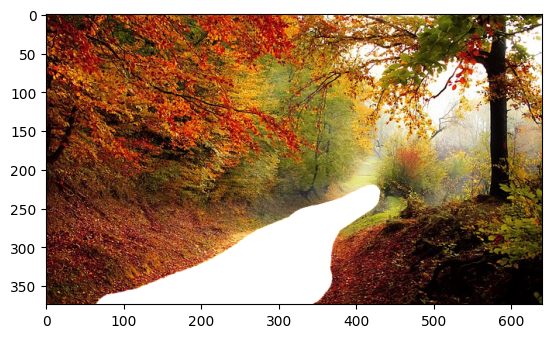

In [2]:
img_name = "forest"

img = cv2.imread(f"examples/inpaint/testImages/{img_name}.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(f"examples/inpaint/masks/{img_name}_mask.png", cv2.IMREAD_GRAYSCALE)

img = (img/255).astype(np.float32)
mask = (mask/255).astype(np.float32)

plt.imshow(img)

368
183
90
44
20
8
nnf shape (12, 20, 2)
nnd shape (12, 20)
(12, 20, 2)


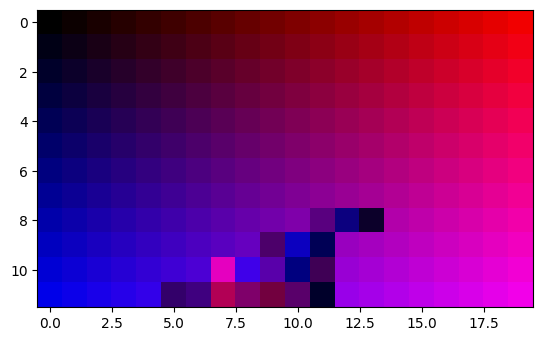

In [3]:
pm = PatchMatch(img, mask, 25)
plt.imshow(pm.visualize())

Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done All Iterations


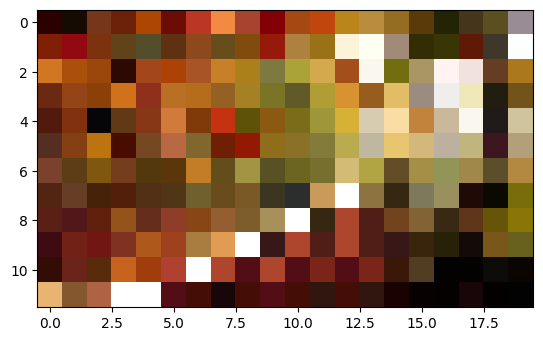

(12, 20, 2)


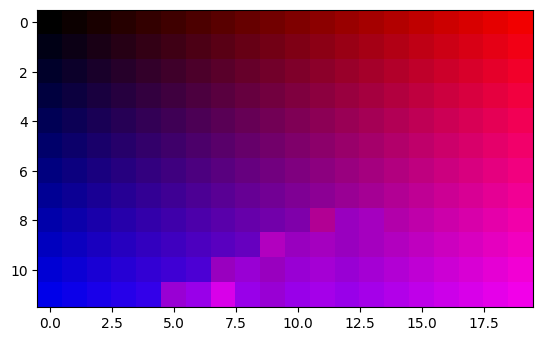

nnf shape (24, 40, 2)
nnd shape (24, 40)
Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done All Iterations


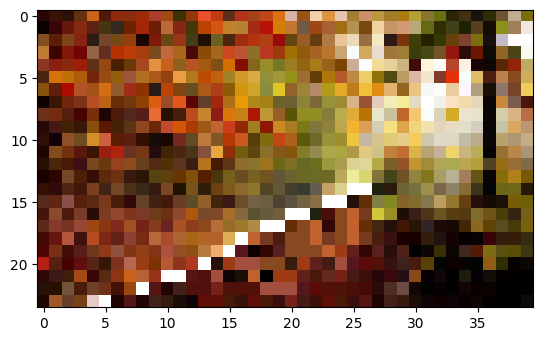

(24, 40, 2)


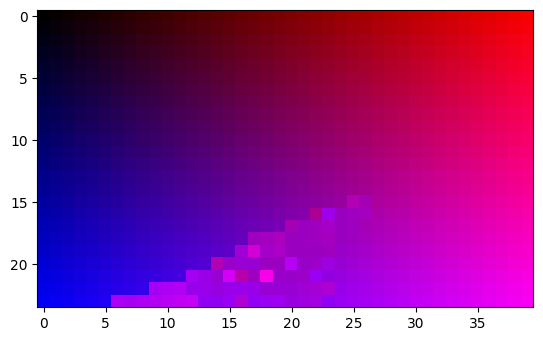

nnf shape (47, 80, 2)
nnd shape (47, 80)
Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done All Iterations


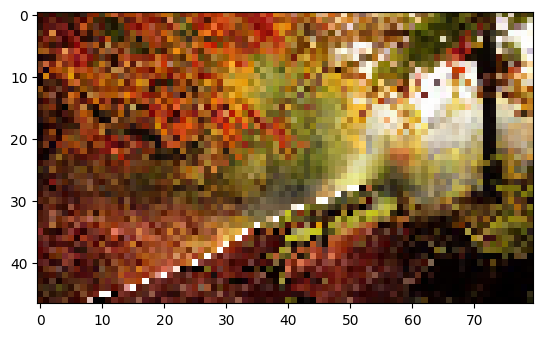

(47, 80, 2)


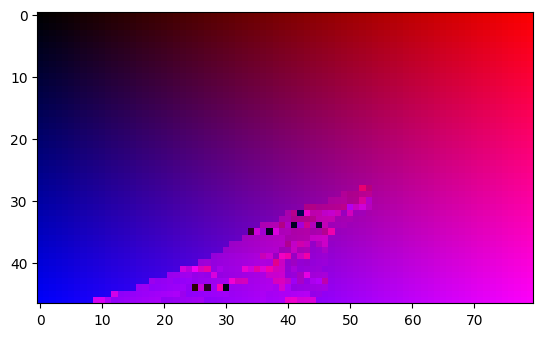

nnf shape (94, 160, 2)
nnd shape (94, 160)
Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done All Iterations


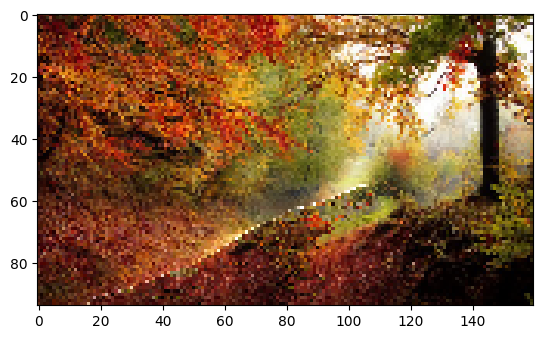

(94, 160, 2)


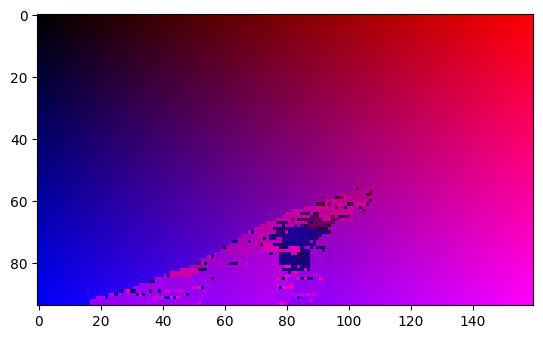

nnf shape (187, 320, 2)
nnd shape (187, 320)
Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done All Iterations


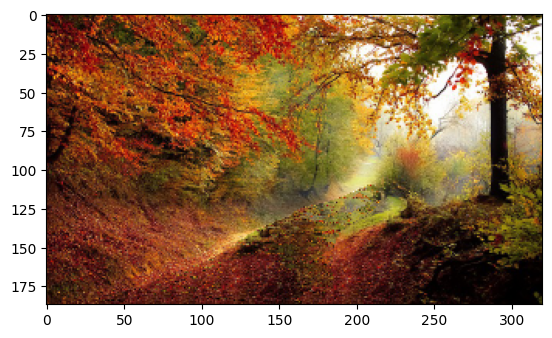

(187, 320, 2)


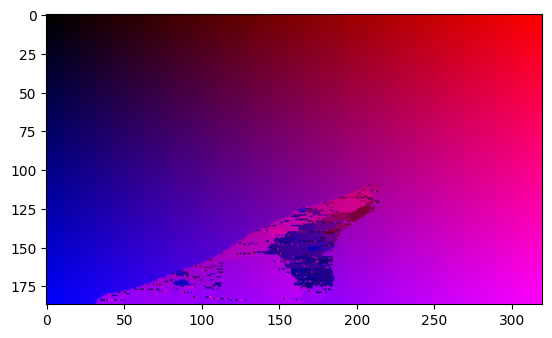

nnf shape (374, 640, 2)
nnd shape (374, 640)
Done iteration 1
Done iteration 2
Done iteration 3
Done iteration 4
Done iteration 5
Done iteration 6
Done All Iterations


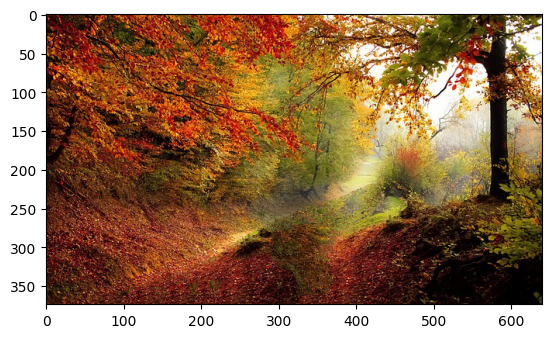

(374, 640, 2)


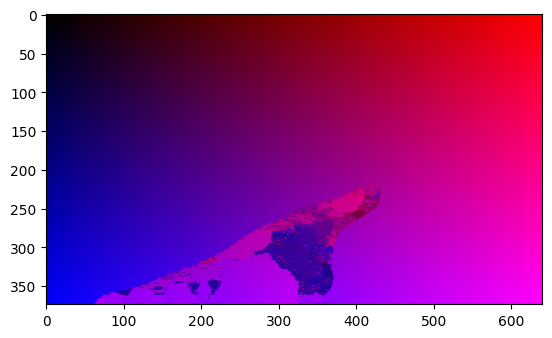

In [4]:
pm.inpaint(iters=6, rand_search_radius=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


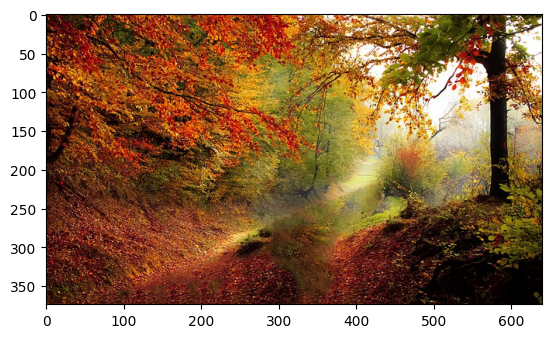

True

In [5]:
out = pm.reconstruct_avg_gaussian(9,3)
plt.imshow(out)
plt.show()

out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
out = (out * 255).astype(int)

cv2.imwrite(f"examples/inpaint/results_mpnn/{img_name}.png", out)